### Audio Recognition for Speech Commands dataset

In [1]:
!pip install pydub

#### 1.1 Importing the Speech Commands dataset

In [2]:
import os
import pathlib
import tensorflow as tf

DATASET_PATH = 'Audio_Dataset_8'
data_dir = pathlib.Path(DATASET_PATH)

In [3]:
#Getting the different commands in the dataset
commands = [x for x in os.listdir(DATASET_PATH) if x != 'README.md']
print(f"Commands : {commands}")

Commands : ['Apple', 'Cat', 'Paper', 'Tree', 'Lamp', 'Fork', 'Sun', 'Car', 'Radio', 'Amazon', 'Television', 'Donut', 'Dog', 'Flower', 'Bike', 'Moon', 'Sandals', 'Chair', 'Soap', 'Shower', 'Pen', 'Pants', 'Netflix', 'Bamboo', 'Internet', 'Table', 'Aeroplane', 'Window', 'Hockey', 'Coffee', 'Towel', 'Umbrella', 'Wallet', 'Phone', 'Keys', 'Hat', 'Banana', 'Backpack', 'Toothpaste', 'Computer', 'Shoes', 'Toothbrush', 'Electricity', 'Shirt', 'Clock', 'Shark', 'Door', 'Knife']


In [4]:
import numpy as np

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
sampling_rate = 48000
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=4,
    validation_split=0.2,
    seed=0,
    output_sequence_length=sampling_rate,
    subset="both"
)

labels = np.array(train_ds.class_names)
print('----------------------------------------------')
print(f'Labels : {labels}')

Found 960 files belonging to 48 classes.
Using 768 files for training.
Using 192 files for validation.
----------------------------------------------
Labels : ['Aeroplane' 'Amazon' 'Apple' 'Backpack' 'Bamboo' 'Banana' 'Bike' 'Car'
 'Cat' 'Chair' 'Clock' 'Coffee' 'Computer' 'Dog' 'Donut' 'Door'
 'Electricity' 'Flower' 'Fork' 'Hat' 'Hockey' 'Internet' 'Keys' 'Knife'
 'Lamp' 'Moon' 'Netflix' 'Pants' 'Paper' 'Pen' 'Phone' 'Radio' 'Sandals'
 'Shark' 'Shirt' 'Shoes' 'Shower' 'Soap' 'Sun' 'Table' 'Television'
 'Toothbrush' 'Toothpaste' 'Towel' 'Tree' 'Umbrella' 'Wallet' 'Window']


### 1.2 Preprocess the data

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
# Squeezing the extra dimension of channels as there is only one

def squeeze(audio, labels) :
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
#Splitting the validation set into validation and test sets

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for sample_audio, sample_labels in train_ds.take(1) :
  print(f"Audio Shape : {sample_audio.shape}")
  print(f"Label Shape : {sample_labels.shape}")

Audio Shape : (4, 48000)
Label Shape : (4,)


In [11]:
from IPython import display
display.display(display.Audio(sample_audio[3], rate=sampling_rate))

### 1.3 Plotting the audio waveforms

In [12]:
labels[[1, 0, 2, 1]]

array(['Amazon', 'Aeroplane', 'Apple', 'Amazon'], dtype='<U11')

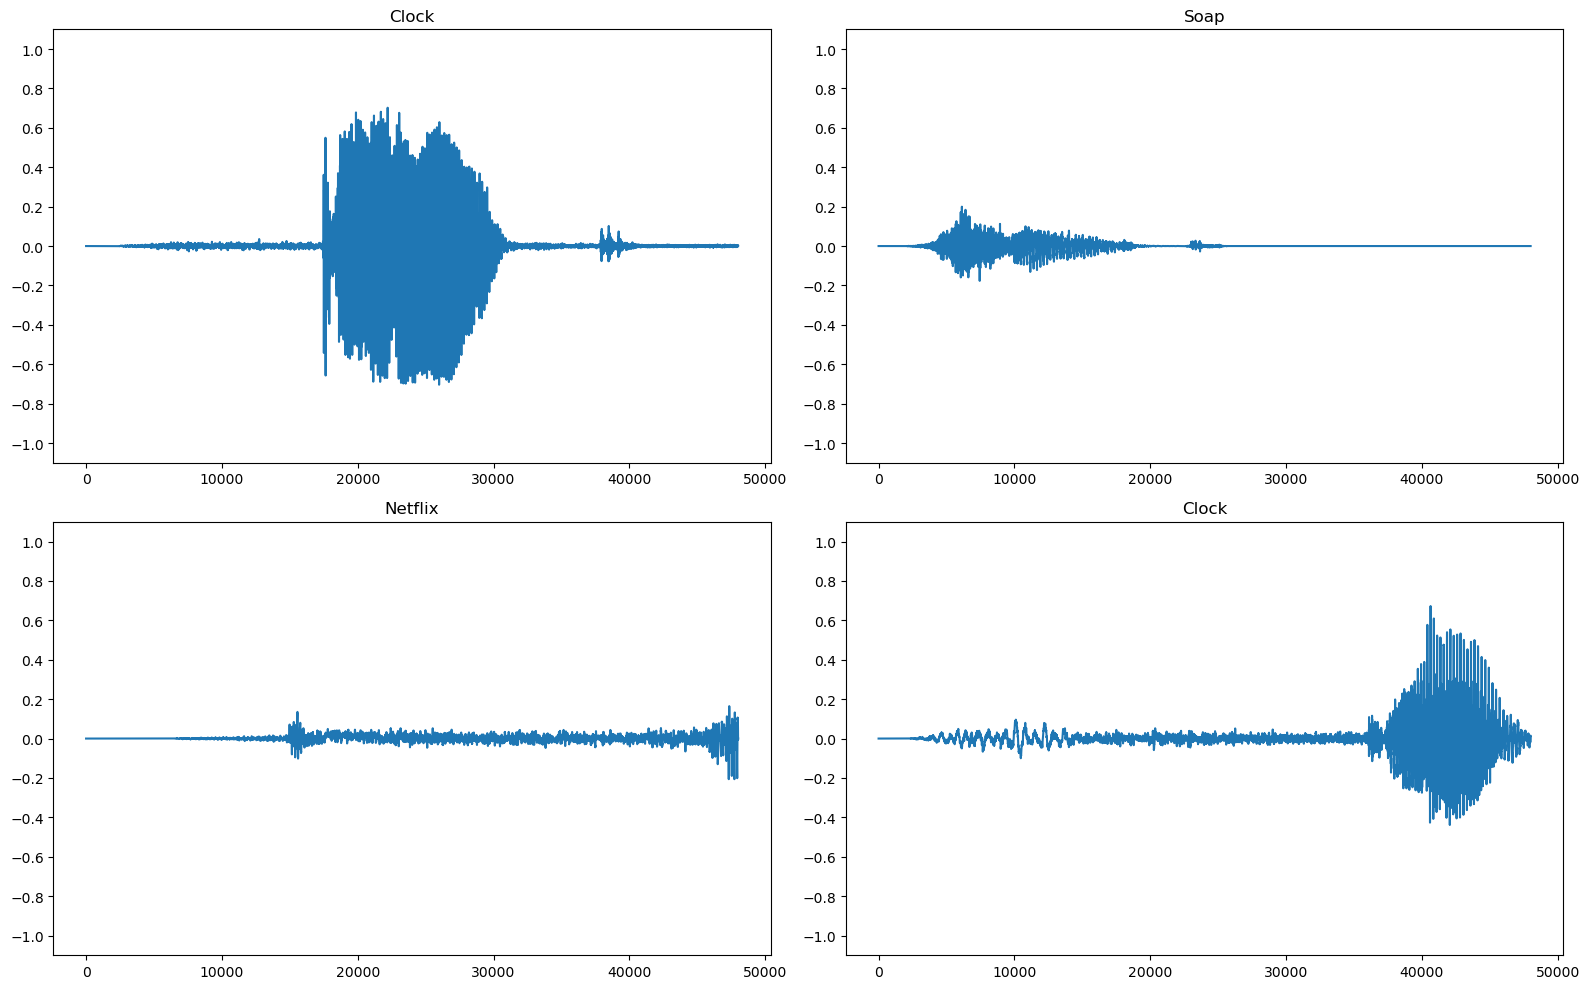

In [13]:
#Creating a plot with 9 audio samples and corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

rows = 2
cols = 2

for i in range(1, rows * cols + 1) :
  plt.subplot(rows, cols, i)
  audio_sample = sample_audio[i-1]
  audio_label = labels[sample_labels[i-1]]
  plt.plot(audio_sample)
  plt.title(audio_label)
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])
  plt.tight_layout()

### 1.4 Converting the audio data waveforms into spectrograms

In [14]:
def get_spectrogram(waveform) :
  # 1. Waveform to Spectrogram using Short-time Fourier Transform
  frame_length = int(sampling_rate * 0.025)  # 25 ms frame length
  frame_step = int(sampling_rate * 0.010)   # 10 ms frame step
  spectrogram = tf.signal.stft(waveform,
                              frame_length=frame_length,
                              frame_step=frame_step)

  # 2. Getting the magnitude of Spectrogram
  spectrogram = tf.abs(spectrogram)

  # 3. Adding a new axis to make it look like (batch, samples, channels) form of an image
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:

from IPython import display

for i in range(3) :
  label = sample_labels[i]
  waveform = sample_audio[i]
  spectrogram = get_spectrogram(waveform)

  print(f"Label            : {labels[label]}")
  print(f"Waveform Shape   : {waveform.shape}")
  print(f"Spectrogram Shape : {spectrogram.shape}")
  display.display(display.Audio(waveform, rate=sampling_rate))

Label            : Clock
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Soap
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Netflix
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


In [16]:
# Plotting the spectrogram

def plot_spectrogram(spectrogram, ax) :

  # 1. Check if length of spectrogram.shape == 3 else raise an AssertionError and squezze the extra dim
  if(len(spectrogram.shape) > 2) :
    # assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # 2. Do a logarithmic transformation on the spectrogram and add a epsilon to avoid taking log(0)
  log_spec = np.log(spectrogram + np.finfo(float).eps)
  height, width = log_spec.shape[0], log_spec.shape[1]

  # 3. Set X and Y for the colormesh
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

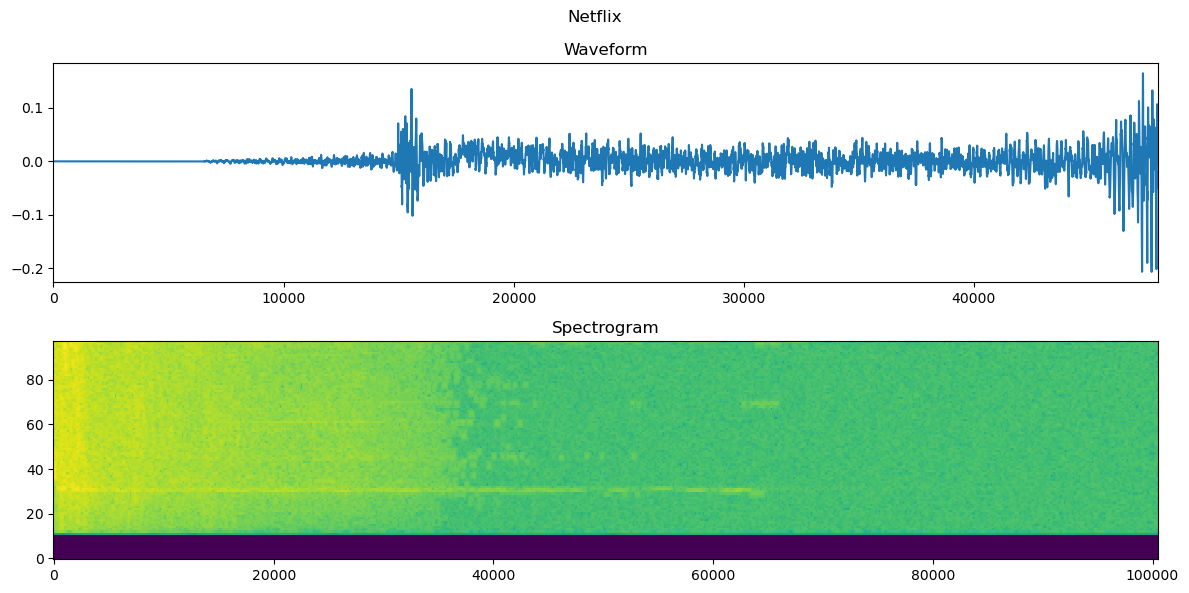

In [17]:
# Plotting the waveform and spectrogram

fig, axes = plt.subplots(2, figsize=(12, 6))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim(0, sampling_rate)

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(labels[label].title())
plt.tight_layout()
plt.show()

### 1.5 Create Spectrogram datasets from waveform data

In [18]:
def make_spec_ds(ds) :
  return ds.map(
      map_func = lambda audio, label : (get_spectrogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE
  )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

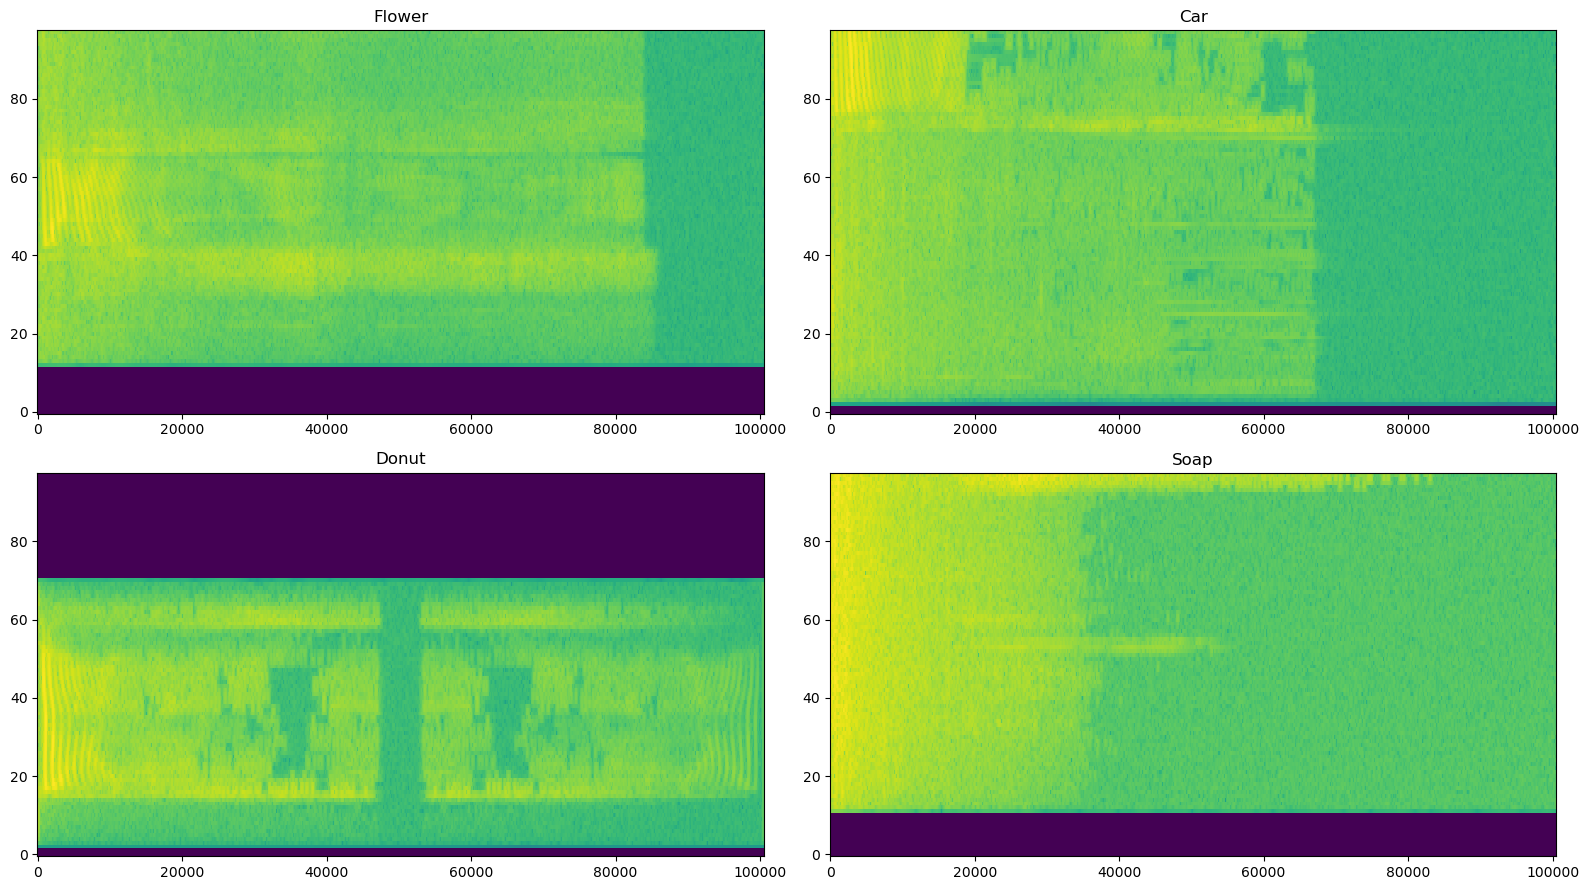

In [19]:
# Plotting the spectrograms

for sample_spect, sample_spect_labels in train_spectrogram_ds.take(1) :
  break

rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n) :
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(sample_spect[i].numpy(), ax)
  ax.set_title(labels[sample_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()

### 2.1 Build and Train the model

In [20]:
# Add cache and prefetch to reduce latency

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
# Building a Convolutional Model as audio data is transformed to spectrogram images

input_shape = sample_spect.shape[1:]
print(f"Input Shape : {input_shape}")
num_labels = len(labels)
print(f"Output Units : {num_labels}")


Input Shape : (98, 1025, 1)
Output Units : 48


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((98, -1)),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=3),
    layers.Dropout(0.35),
    # Replace LSTM with GRU, ensuring correct return_sequences
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 98, 1025)          0         
                                                                 
 conv1d (Conv1D)             (None, 94, 64)            328064    
                                                                 
 max_pooling1d (MaxPooling1  (None, 31, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 64)            0         
                                                                 
 bidirectional (Bidirection  (None, 31, 256)           148992    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               2

In [23]:
# Configuring the model Adam Optimizer and SparseCategoricalCrossentropy

model_1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

In [24]:
# Training the model for 30 epochs

EPOCHS = 40

history = model_1.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = EPOCHS
)

Epoch 1/40


/Users/anand/miniconda3/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


192/192 [==============================] - 7s 23ms/step - loss: 3.9396 - accuracy: 0.0326 - val_loss: 3.7763 - val_accuracy: 0.0625
Epoch 2/40
192/192 [==============================] - 4s 20ms/step - loss: 3.6216 - accuracy: 0.0846 - val_loss: 3.4313 - val_accuracy: 0.1354
Epoch 3/40
192/192 [==============================] - 4s 19ms/step - loss: 3.2518 - accuracy: 0.1432 - val_loss: 3.2148 - val_accuracy: 0.1146
Epoch 4/40
192/192 [==============================] - 4s 19ms/step - loss: 2.8981 - accuracy: 0.2396 - val_loss: 2.8010 - val_accuracy: 0.2604
Epoch 5/40
192/192 [==============================] - 4s 19ms/step - loss: 2.5925 - accuracy: 0.3034 - val_loss: 2.5069 - val_accuracy: 0.3333
Epoch 6/40
192/192 [==============================] - 4s 19ms/step - loss: 2.3064 - accuracy: 0.3503 - val_loss: 2.3587 - val_accuracy: 0.3438
Epoch 7/40
192/192 [==============================] - 4s 19ms/step - loss: 2.0216 - accuracy: 0.4049 - val_loss: 2.1806 - val_accuracy: 0.4375
Epoch 8/40

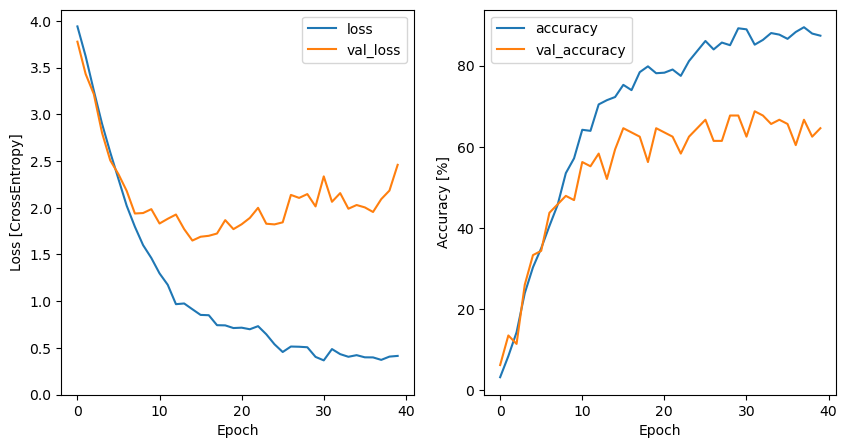

In [25]:
#Plotting the Loss and Accuracy Curves

metrics = history.history

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylim(0, max(plt.ylim()))
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

### 3.1 Evaluate the model performance

In [26]:
model_1.evaluate(test_spectrogram_ds, return_dict=True)

24/24 [==============================] - 0s 5ms/step - loss: 2.2516 - accuracy: 0.6458


{'loss': 2.251596689224243, 'accuracy': 0.6458333134651184}

### 3.2 Display a Confusion Matrix

In [27]:
y_pred = tf.argmax(model_1.predict(test_spectrogram_ds), axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, label : label)), axis=0)

24/24 [==============================] - 1s 5ms/step


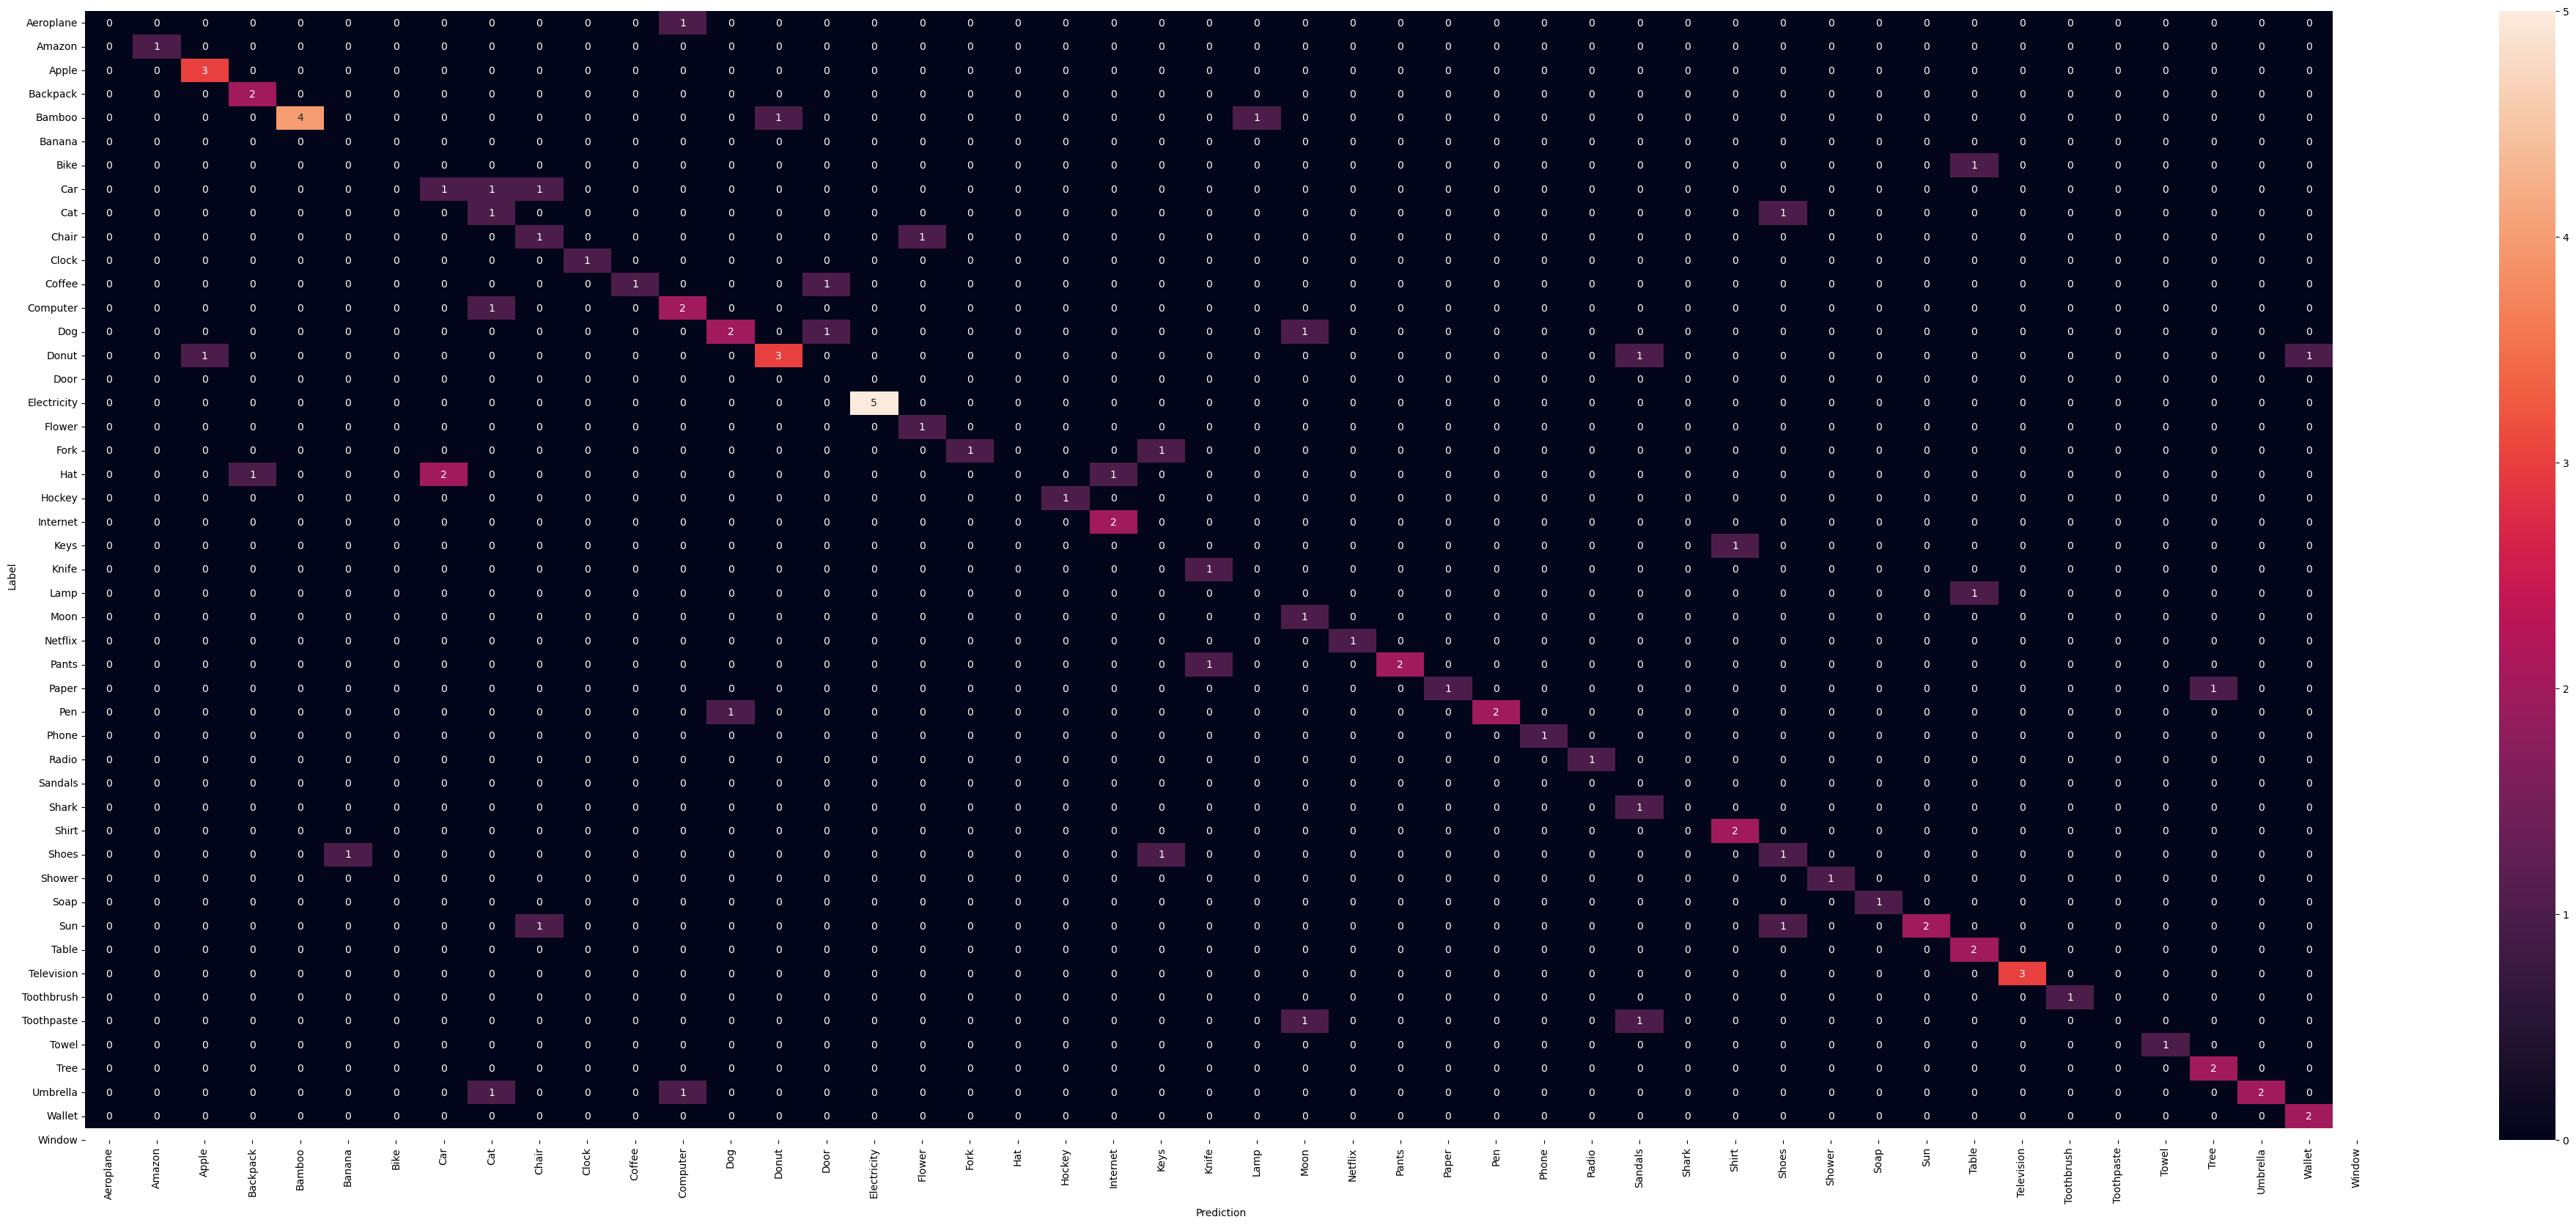

In [28]:
import seaborn as sns

conf_mat = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(50, 20))
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### 3.3 Run inference on random audio file

In [29]:
data_dir

PosixPath('Audio_Dataset_8')

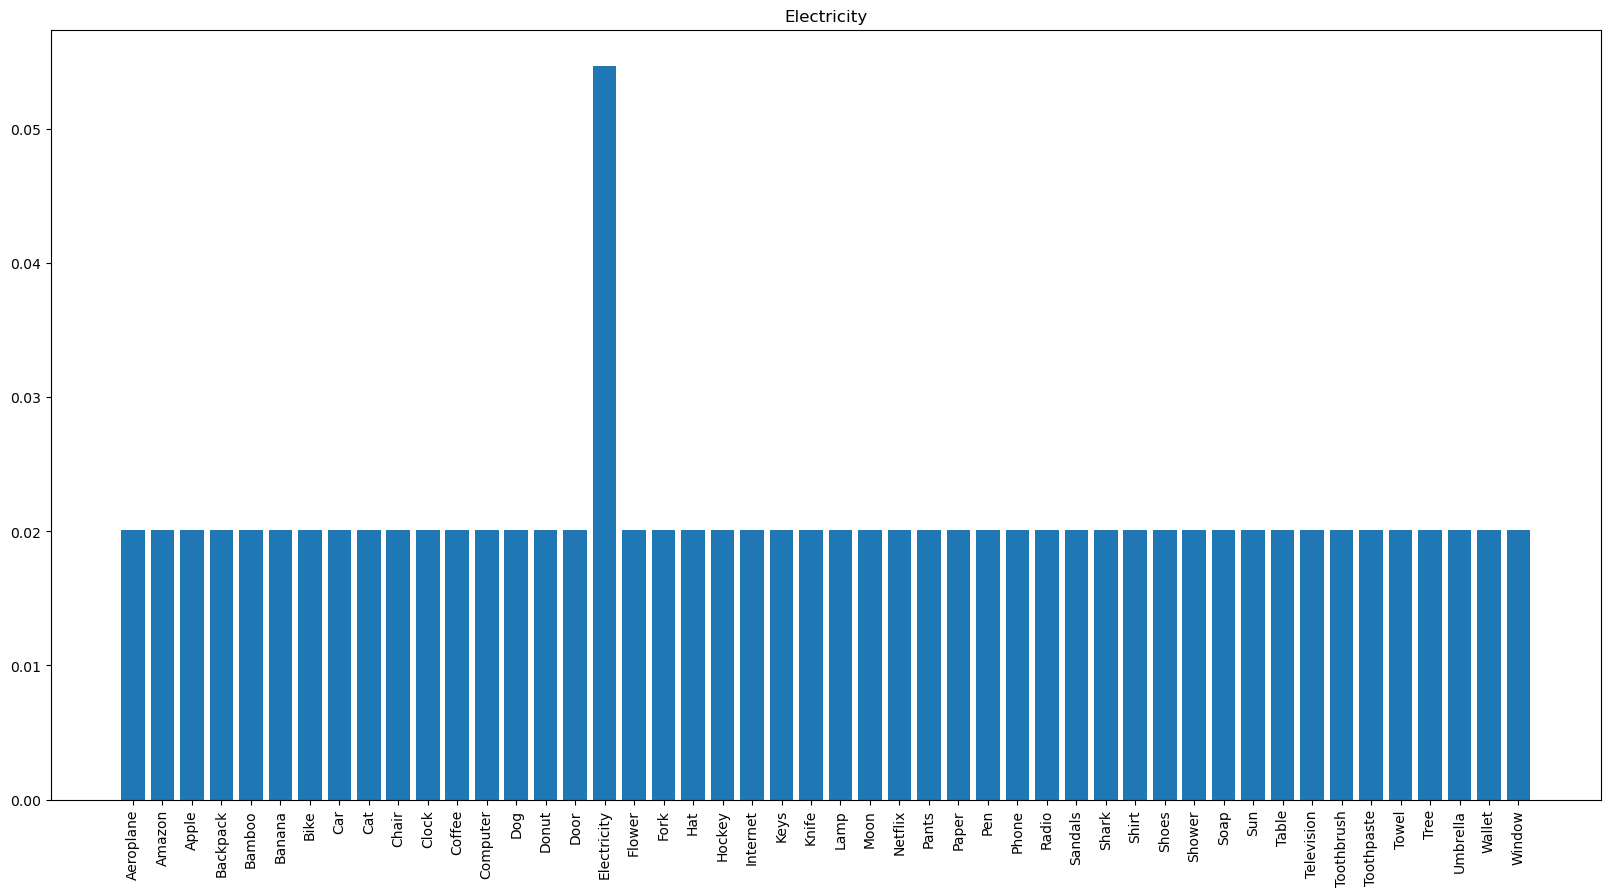

In [30]:
x = data_dir/'Electricity'/'Electricity_0005.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sampling_rate)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]
pred = model_1(x)
plt.figure(figsize=(20, 10))
plt.bar(labels, tf.nn.softmax(pred[0]))
plt.title('Electricity')
plt.xticks(rotation='vertical')
plt.show()

display.display(display.Audio(waveform, rate=sampling_rate))

### 4. Export the model with preprocessing steps


In [31]:
class ExportModel(tf.Module) :
  def __init__(self, model) :

    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string),
    )
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, sampling_rate], dtype=tf.float32)
    )

  @tf.function
  def __call__(self, x) :
    if x.dtype == tf.string :
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sampling_rate,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, ...]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(labels, class_ids)
    return {
        'predictions' : result,
        'class_ids' : class_ids,
        'class_names' : class_names
    }


In [32]:
# Test run the export model

export = ExportModel(model_1)
export(tf.constant(str(data_dir/'Apple/Apple_0002.wav')))

{'predictions': <tf.Tensor: shape=(1, 48), dtype=float32, numpy=
 array([[2.57486166e-09, 7.02445671e-11, 9.89480972e-01, 6.32714148e-07,
         1.61084739e-04, 1.01947878e-02, 1.07753936e-11, 2.54296528e-10,
         4.24937238e-11, 2.06755484e-13, 9.88558714e-12, 2.48440092e-12,
         5.46207107e-11, 1.61992801e-07, 1.68091763e-08, 4.40769332e-09,
         4.32785863e-10, 2.65590874e-08, 1.16170944e-11, 1.46971552e-05,
         3.70444120e-10, 2.37163345e-10, 3.62974859e-11, 3.83285336e-13,
         1.66621023e-10, 2.33496625e-11, 1.34632637e-12, 3.77735647e-12,
         2.18883685e-08, 1.25761456e-12, 9.06578957e-14, 6.28645864e-07,
         7.13756853e-14, 4.47121842e-08, 1.79217335e-11, 1.18293472e-12,
         1.43173107e-04, 1.66226421e-14, 2.66046230e-15, 9.44478260e-14,
         3.57958829e-10, 2.93996605e-10, 3.07085524e-10, 2.66175859e-10,
         3.72165189e-13, 1.53651447e-09, 3.81553218e-06, 9.22170191e-14]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(

In [33]:
# Save and reload the model

tf.saved_model.save(export, 'saved')
reloaded_model = tf.saved_model.load('saved')


INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [34]:
print(reloaded_model(waveform[tf.newaxis, :]))

{'predictions': <tf.Tensor: shape=(1, 48), dtype=float32, numpy=
array([[2.9279352e-07, 2.1445641e-14, 7.0892250e-12, 2.6626220e-11,
        1.6050015e-13, 3.6485381e-12, 2.3547957e-06, 7.4675743e-16,
        1.7262193e-10, 1.9831520e-10, 9.9877420e-13, 6.9582534e-11,
        1.1223084e-14, 7.3985626e-15, 2.3894181e-12, 1.2950706e-13,
        9.9999261e-01, 2.6806149e-11, 2.4988612e-14, 7.9385085e-09,
        6.0847472e-10, 9.9189390e-10, 6.9103118e-10, 1.7670208e-06,
        5.3002662e-08, 1.5169374e-14, 1.2599409e-10, 3.3742957e-08,
        7.4525291e-10, 2.2885088e-07, 6.0930525e-13, 9.5556119e-10,
        3.0406813e-08, 1.9363923e-10, 2.4174190e-07, 2.7602738e-07,
        1.2773865e-11, 6.1232155e-13, 2.9610108e-09, 2.2792138e-10,
        1.1123013e-06, 2.1327299e-11, 9.5336884e-11, 4.2148556e-09,
        1.1218979e-06, 1.6938443e-15, 4.0394554e-13, 1.2294428e-10]],
      dtype=float32)>, 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([16])>, 'class_names': <tf.Tenso

In [35]:
waveform.shape

TensorShape([48000])

In [36]:
waveform[tf.newaxis, :]

<tf.Tensor: shape=(1, 48000), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ..., -0.00384521,
        -0.00387573, -0.00683594]], dtype=float32)>